Simulated Annealing

In [24]:
import pandas as pd
import numpy as np
import random
from enum import Enum, auto
from dataclasses import dataclass
from typing import Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Dict
import tkinter as tk
from tkinter import messagebox
from tkinter import font as tkFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [31]:
file_path = "./mall_customers_preprocessed.csv"
df = pd.read_csv(file_path)

print(df.info)

<bound method DataFrame.info of      Gender       Age  Annual Income (k$)  Spending Score (1-100)
0       1.0  0.019231            0.000000                0.387755
1       1.0  0.057692            0.000000                0.816327
2       0.0  0.038462            0.008197                0.051020
3       0.0  0.096154            0.008197                0.775510
4       0.0  0.250000            0.016393                0.397959
..      ...       ...                 ...                     ...
195     0.0  0.326923            0.860656                0.795918
196     0.0  0.519231            0.909836                0.275510
197     1.0  0.269231            0.909836                0.744898
198     1.0  0.269231            1.000000                0.173469
199     1.0  0.230769            1.000000                0.836735

[200 rows x 4 columns]>


In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

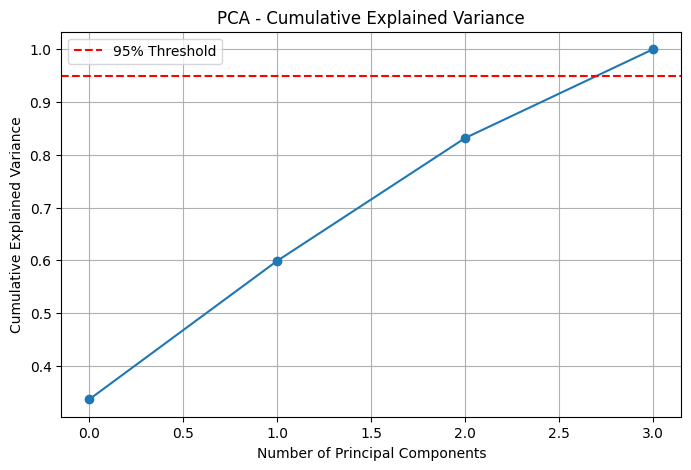

In [34]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [42]:
pca_reduced = PCA(n_components=3)
X_reduced = pca_reduced.fit_transform(X_scaled)

df_reduced = pd.DataFrame(X_reduced, columns=['PC1', 'PC2', 'PC3'])

print(df_reduced.head())

        PC1       PC2       PC3
0 -0.406383 -0.520714  2.072527
1 -1.427673 -0.367310  2.277644
2  0.050761 -1.894068  0.367375
3 -1.694513 -1.631908  0.717467
4 -0.313108 -1.810483  0.426460


In [61]:
class CoolingType(Enum):
    EXPONENTIAL = auto()
    LINEAR = auto()
    VCM = auto()
    ADAPTIVE = auto()

class IntializationType(Enum):
    RANDOM = auto()
    KMEANS = auto()

@dataclass
class SAConfig:
    initial_temp: float = 1000.0
    _initialize_centroids: IntializationType = IntializationType.RANDOM
    cooling_rate: float = 0.95
    cooling_type: CoolingType = CoolingType.EXPONENTIAL
    max_iter: int = 1000
    termination_cost: float = 0.0
    reheat_interval : int  = 100
    reaheat_temp : float = 1000.0
    reheat_enabled: bool = False
    local_search_freq: int = 0
    perturbation_scale: float = 0.5
    min_temp: float = 1.0
    num_clusters: int = 3


In [66]:
class SimulatedAnnealingClustering:
    def __init__(self, objective, data: np.ndarray, config: SAConfig):
        self.objective = objective
        self.data = data
        self.config = config
        self.temp = config.initial_temp
        self.iteration = 0
        self.acceptance_history = []


        n_samples, n_features = data.shape
        if self.config._initialize_centroids==IntializationType.RANDOM:
          self.curr_solution = self._initialize_centroids(n_samples, n_features)
        else:
          self.curr_solution = self._initialize_centroids_kmeans(n_samples, n_features)

        self.curr_cost = objective(self.curr_solution)
        self.best_solution = self.curr_solution.copy()
        self.best_cost = self.curr_cost
        self.cost_history = [self.curr_cost]

    def _initialize_centroids(self, n_samples: int, n_features: int) -> np.ndarray:
        centroids = self.data[np.random.choice(n_samples,size = self.config.num_clusters, replace=False)]
        return centroids

    def _initialize_centroids_kmeans(self, n_samples: int, n_features: int) -> np.ndarray:
        centroids = np.zeros((self.config.num_clusters, n_features))

        centroids[0] = self.data[np.random.choice(n_samples)]

        for i in range(1, self.config.num_clusters):
            distances = np.min(np.sum((self.data[:, np.newaxis] - centroids[:i]) ** 2, axis=2), axis=1)
            probabilities = distances / np.sum(distances)
            centroids[i] = self.data[np.random.choice(n_samples, p=probabilities)]

        return centroids

    def _perturb_centroids(self) -> np.ndarray:
        noise = np.random.normal(
            scale = self.config.perturbation_scale * (self.temp / self.config.initial_temp),
            size = self.curr_solution.shape
        )
        return np.clip(
            self.curr_solution + noise,
            self.data.min(axis=0),
            self.data.max(axis=0)
        )

    def _local_search(self) -> np.ndarray:
        distances = np.linalg.norm(self.data[:, np.newaxis] - self.curr_solution, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = []
        for i in range(self.config.num_clusters):
            cluster_points = self.data[labels == i]
            if len(cluster_points) == 0:
                new_centroids.append(self.data[np.random.choice(len(self.data))])
            else:
                new_centroids.append(cluster_points.mean(axis=0))

        return np.array(new_centroids)

    def _accept_solution(self, new_cost: float) -> bool:
        if new_cost < self.curr_cost:
            return True

        delta = new_cost - self.curr_cost
        acceptance_prob = np.exp(-delta / self.temp)
        self.acceptance_history.append(acceptance_prob)
        return random.random() < acceptance_prob

    def _update_temperature(self, iteration: int):

        if self.config.cooling_type == CoolingType.EXPONENTIAL:
            self.temp = self.config.initial_temp * (self.config.cooling_rate ** iteration)

        elif self.config.cooling_type == CoolingType.LINEAR:
            self.temp = self.config.initial_temp * (1 - iteration / self.config.max_iter)

        elif self.config.cooling_type == CoolingType.VCM:
            d = self.data.shape[1]
            self.temp = self.config.initial_temp * np.exp(
                -self.config.cooling_rate * (iteration ** (-1 / d))
            )

        elif self.config.cooling_type == CoolingType.ADAPTIVE:
            window_size = min(50, iteration + 1)
            recent_acceptance = np.mean(self.acceptance_history[-window_size:]) if self.acceptance_history else 1.0
            if recent_acceptance < 0.2:
                self.temp *= 1.05
            elif recent_acceptance > 0.5:
                self.temp *= 0.95
            else:
                self.temp *= self.config.cooling_rate

        ## self.temp = max(self.temp, self.config.min_temp)

    def run(self) -> Tuple[np.ndarray, float]:
        """
        Run the simulated annealing clustering algorithm

        Returns:
            Tuple of (best_solution, best_cost)
        """
        for self.iteration in range(1, self.config.max_iter):
            new_solution = self._perturb_centroids()

            if self.config.local_search_freq > 0 and self.iteration % self.config.local_search_freq == 0:
                new_solution = self._local_search()

            new_cost = self.objective(new_solution)

            if self._accept_solution(new_cost):
                self.curr_solution = new_solution
                self.curr_cost = new_cost

                if new_cost < self.best_cost:
                    self.best_solution = new_solution.copy()
                    self.best_cost = new_cost

            self.cost_history.append(self.curr_cost)
            self._update_temperature(self.iteration)
            if self.curr_cost <= self.config.termination_cost:
                break

        return self.best_solution, self.best_cost


In [64]:
def kmeans_cost(centroids: np.ndarray, data: np.ndarray) -> float:
    distances = np.sum((data[:, np.newaxis] - centroids) ** 2, axis=2)
    return np.sum(np.min(distances, axis=1))

In [69]:
data = df_reduced.values
config = SAConfig(
    num_clusters=5,
    cooling_type=CoolingType.EXPONENTIAL,
    cooling_rate=0.93,
    max_iter=500
)

sa = SimulatedAnnealingClustering(
    objective=lambda x: kmeans_cost(x, data),
    data=data,
    config=config
)
centroids, cost = sa.run()

print(f"Best cost: {cost:.2f}")
print("Centroids:\n", centroids)


Best cost: 365.33
Centroids:
 [[-1.90386557 -1.10444099  0.33857796]
 [-1.01540884  0.27877613 -1.10253792]
 [ 1.33287409  1.05558682  0.19149482]
 [ 0.15993794 -0.42329307 -0.878706  ]
 [ 1.09288835  0.98284085 -2.37186351]]


In [70]:

def run_experiments(data: np.ndarray, configs: List[SAConfig],
                    num_runs: int = 1000000, objective=None) -> Dict:
    """
    Run multiple SA configurations and collect statistics

    Args:
        data: Input data matrix
        configs: List of SAConfig objects to test
        num_runs: Number of runs per configuration
        objective: Cost function (default: kmeans_cost)

    Returns:
        Dictionary containing all results and statistics
    """
    if objective is None:
        objective = lambda x: kmeans_cost(x, data)

    results = {
        'configs': configs,
        'all_runs': [],
        'statistics': []
    }

    # Run each configuration multiple times
    for config in tqdm(configs, desc="Testing configurations"):
        config_runs = []
        for run in range(num_runs):
            sa = SimulatedAnnealingClustering(objective, data, config)
            centroids, final_cost = sa.run()

            config_runs.append({
                'cost_history': sa.cost_history,
                'final_cost': final_cost,
                'centroids': centroids,
                'acceptance_history': sa.acceptance_history
            })

        # Calculate statistics for this configuration
        final_costs = [run['final_cost'] for run in config_runs]
        avg_cost = np.mean(final_costs)
        std_cost = np.std(final_costs)

        results['all_runs'].append(config_runs)
        results['statistics'].append({
            'config': config,
            'avg_cost': avg_cost,
            'std_cost': std_cost,
            'min_cost': np.min(final_costs),
            'max_cost': np.max(final_costs),
            'stuck_probability': np.mean(np.array(final_costs) > 1.1 * np.min(final_costs))
        })

    return results



In [71]:
def plot_convergence_comparison(results: Dict):
    """Plot average convergence for each configuration"""
    plt.figure(figsize=(12, 6))

    for i, config_runs in enumerate(results['all_runs']):
        # Get all cost histories for this config
        histories = [run['cost_history'] for run in config_runs]

        # Pad histories to equal length for averaging
        max_len = max(len(h) for h in histories)
        padded = [h + [h[-1]] * (max_len - len(h)) for h in histories]

        # Calculate mean and std across runs
        mean_history = np.mean(padded, axis=0)
        std_history = np.std(padded, axis=0)

        # Plot with confidence bands
        config_name = results['configs'][i].cooling_type.name
        plt.plot(mean_history, label=f"{config_name}")
        plt.fill_between(
            range(len(mean_history)),
            mean_history - std_history,
            mean_history + std_history,
            alpha=0.2
        )

    plt.title("Average Convergence Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True)
    plt.show()



In [72]:
def plot_stuck_probability(results: Dict):
    """Visualize probability of getting stuck in local minima"""
    stats = results['statistics']
    config_names = [s['config'].cooling_type.name for s in stats]
    stuck_probs = [s['stuck_probability'] for s in stats]
    avg_final_costs = [s['avg_cost'] for s in stats]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Probability of getting stuck
    ax1.bar(config_names, stuck_probs)
    ax1.set_title("Probability of Getting Stuck in Local Minima")
    ax1.set_ylabel("Probability")
    ax1.set_ylim(0, 1)

    # Average final costs
    ax2.bar(config_names, avg_final_costs)
    ax2.set_title("Average Final Cost Across Runs")
    ax2.set_ylabel("Cost")

    plt.tight_layout()
    plt.show()


In [73]:
def start_experiment():
    messagebox.showinfo("Experiment", "Running experiments... This may take a while!")

    # Run experiments (same as your __main__ block)
    results = run_experiments(data, configs, num_runs=10)

    # Show plots
    plot_convergence_comparison(results)
    plot_stuck_probability(results)

    # Print summary in a popup
    summary = ""
    for stat in results['statistics']:
        summary += f"\n{stat['config'].cooling_type.name}:\n"
        summary += f"  Avg Cost: {stat['avg_cost']:.2f} ± {stat['std_cost']:.2f}\n"
        summary += f"  Stuck Probability: {stat['stuck_probability']:.2f}\n"
        summary += f"  Best Run: {stat['min_cost']:.2f}\n"
        summary += f"  Worst Run: {stat['max_cost']:.2f}\n"

    messagebox.showinfo("Results Summary", summary)


Testing configurations: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


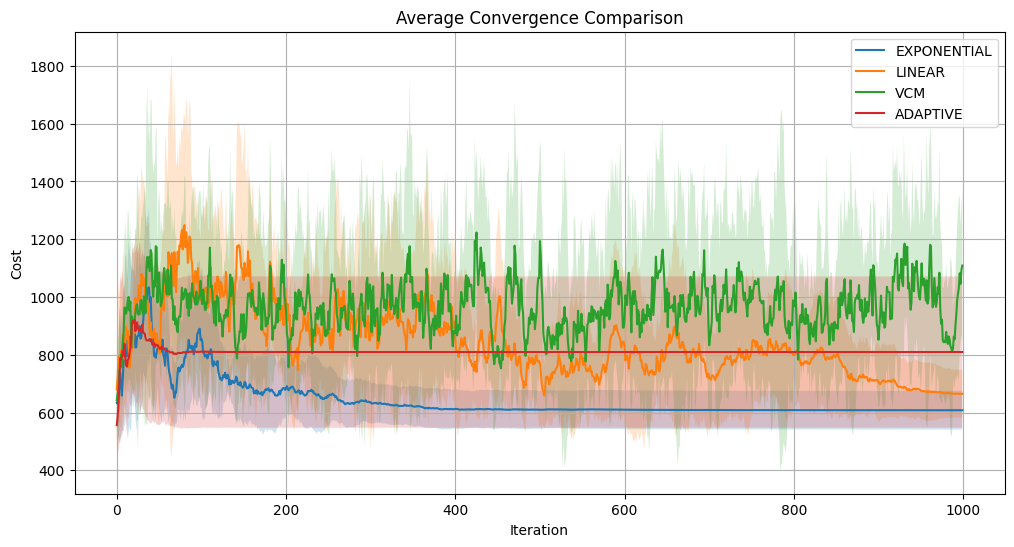

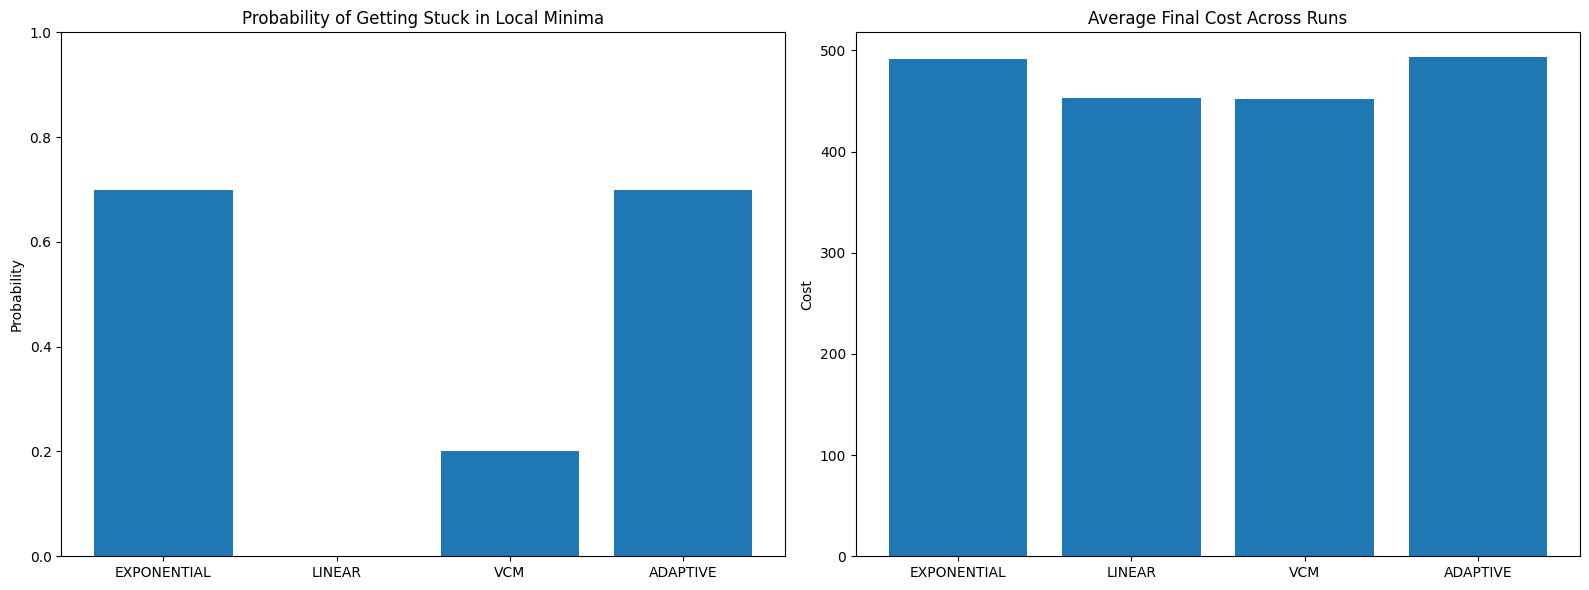


EXPONENTIAL:

  Avg Cost: 491.77 ± 64.25
  Stuck Probability: 0.70
  Best Run: 407.93
  Worst Run: 610.51

LINEAR:

  Avg Cost: 453.09 ± 12.53
  Stuck Probability: 0.00
  Best Run: 440.84
  Worst Run: 480.91

VCM:

  Avg Cost: 452.09 ± 38.58
  Stuck Probability: 0.20
  Best Run: 419.79
  Worst Run: 555.82

ADAPTIVE:

  Avg Cost: 493.13 ± 57.70
  Stuck Probability: 0.70
  Best Run: 402.17
  Worst Run: 606.52


In [74]:
configs = [
    SAConfig(cooling_type=CoolingType.EXPONENTIAL, cooling_rate=0.99),
    SAConfig(cooling_type=CoolingType.LINEAR),
    SAConfig(cooling_type=CoolingType.VCM, cooling_rate=0.01),
    SAConfig(cooling_type=CoolingType.ADAPTIVE)
]

results = run_experiments(data, configs, num_runs=10)

plot_convergence_comparison(results)
plot_stuck_probability(results)

for stat in results['statistics']:
    print(f"\n{stat['config'].cooling_type.name}:\n")
    print(f"  Avg Cost: {stat['avg_cost']:.2f} ± {stat['std_cost']:.2f}")
    print(f"  Stuck Probability: {stat['stuck_probability']:.2f}")
    print(f"  Best Run: {stat['min_cost']:.2f}")
    print(f"  Worst Run: {stat['max_cost']:.2f}")
